In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'
warnings.filterwarnings('ignore')

train = pd.read_csv('sales_train.csv')

In [2]:
train = train[train['item_cnt_day'] > 0]
grouped = train[['date_block_num', 'shop_id', 'item_cnt_day']].groupby(['date_block_num', 'shop_id']).sum().reset_index()

In [3]:
for month in range(12):
    grouped['date_block_num'].replace({month: '2013-'+str(month+1)}, inplace=True)
    
for month in range(12, 24):
    grouped['date_block_num'].replace({month: '2014-'+str(month - 11)}, inplace=True)
    
for month in range(24,34):
    grouped['date_block_num'].replace({month: '2015-'+str(month-23)}, inplace=True)
grouped['date_block_num'] = pd.to_datetime(grouped['date_block_num'])
grouped['date_block_num'] = grouped['date_block_num'].dt.strftime('%Y/%m')

In [4]:
grouped = grouped.pivot('shop_id', 'date_block_num', 'item_cnt_day').fillna(0)
grouped.head()

date_block_num,2013/01,2013/02,2013/03,2013/04,2013/05,2013/06,2013/07,2013/08,2013/09,2013/10,...,2015/01,2015/02,2015/03,2015/04,2015/05,2015/06,2015/07,2015/08,2015/09,2015/10
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2947.0,3364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1151.0,489.0,756.0,585.0,553.0,832.0,809.0,878.0,949.0,798.0,...,989.0,916.0,766.0,862.0,846.0,807.0,789.0,943.0,825.0,727.0
3,767.0,801.0,959.0,648.0,718.0,789.0,729.0,891.0,1031.0,798.0,...,982.0,739.0,747.0,741.0,734.0,676.0,542.0,668.0,749.0,616.0
4,2117.0,2036.0,2069.0,287.0,1212.0,1465.0,1384.0,1718.0,1536.0,1486.0,...,1192.0,981.0,981.0,902.0,896.0,797.0,844.0,948.0,734.0,831.0


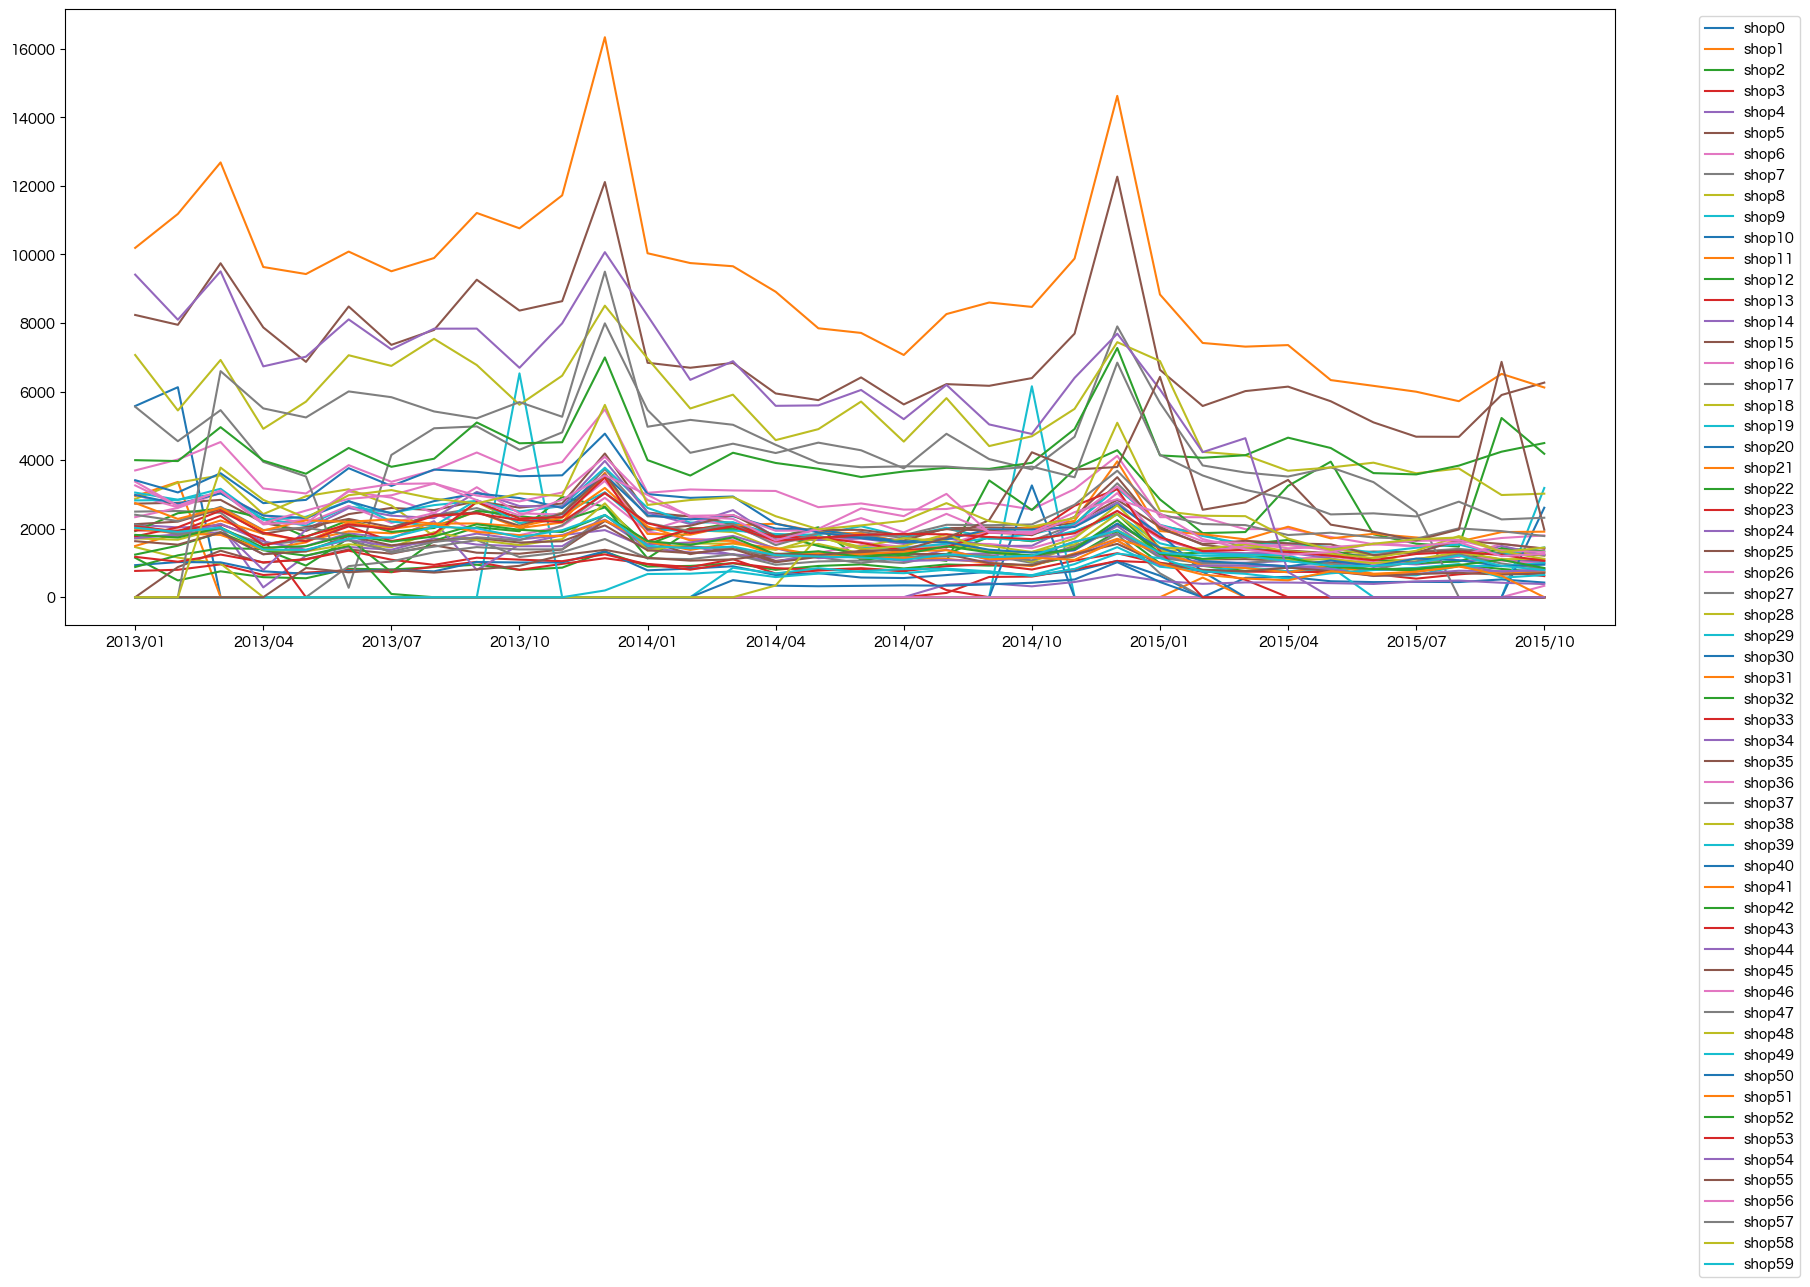

In [5]:
time_np = to_time_series_dataset(grouped)

x_labels = ['2013/01', '2013/02', '2013/03', '2013/04', '2013/05', '2013/06',
       '2013/07', '2013/08', '2013/09', '2013/10', '2013/11', '2013/12',
       '2014/01', '2014/02', '2014/03', '2014/04', '2014/05', '2014/06',
       '2014/07', '2014/08', '2014/09', '2014/10', '2014/11', '2014/12',
       '2015/01', '2015/02', '2015/03', '2015/04', '2015/05', '2015/06',
       '2015/07', '2015/08', '2015/09', '2015/10']

fig, ax = plt.subplots(figsize=(20, 8))

for i, x in enumerate(time_np[:]):
    ax.plot(x, label='shop'+str(i))

ticks_space = 3
ax.set_xticks(range(0, len(x_labels), ticks_space))
ax.set_xticklabels([label for label in x_labels][::ticks_space])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

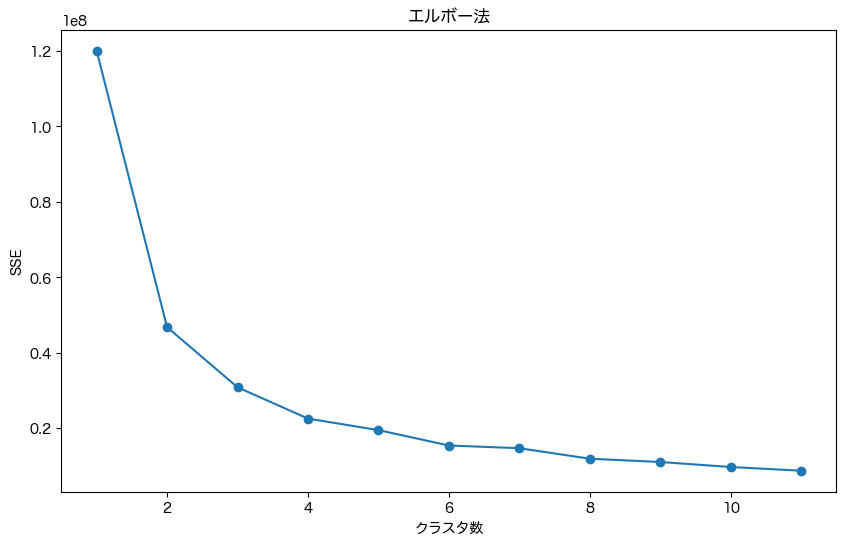

In [6]:
inertia = []
for n_cluster in range(1,12):
    km = TimeSeriesKMeans(n_clusters=n_cluster, metric='euclidean', random_state=0)
    km.fit(time_np)
    inertia.append(km.inertia_)
    
plt.figure(figsize=(10, 6))
plt.plot(range(1,12), inertia, marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('SSE')
plt.title('エルボー法')
plt.show()

[2 2 2 2 0 0 3 0 2 2 2 2 0 2 0 0 0 2 0 0 2 0 0 2 0 1 0 3 1 0 0 1 2 2 2 0 2
 0 0 2 2 0 3 0 0 0 0 0 2 2 0 0 0 0 1 0 0 3 0 0]


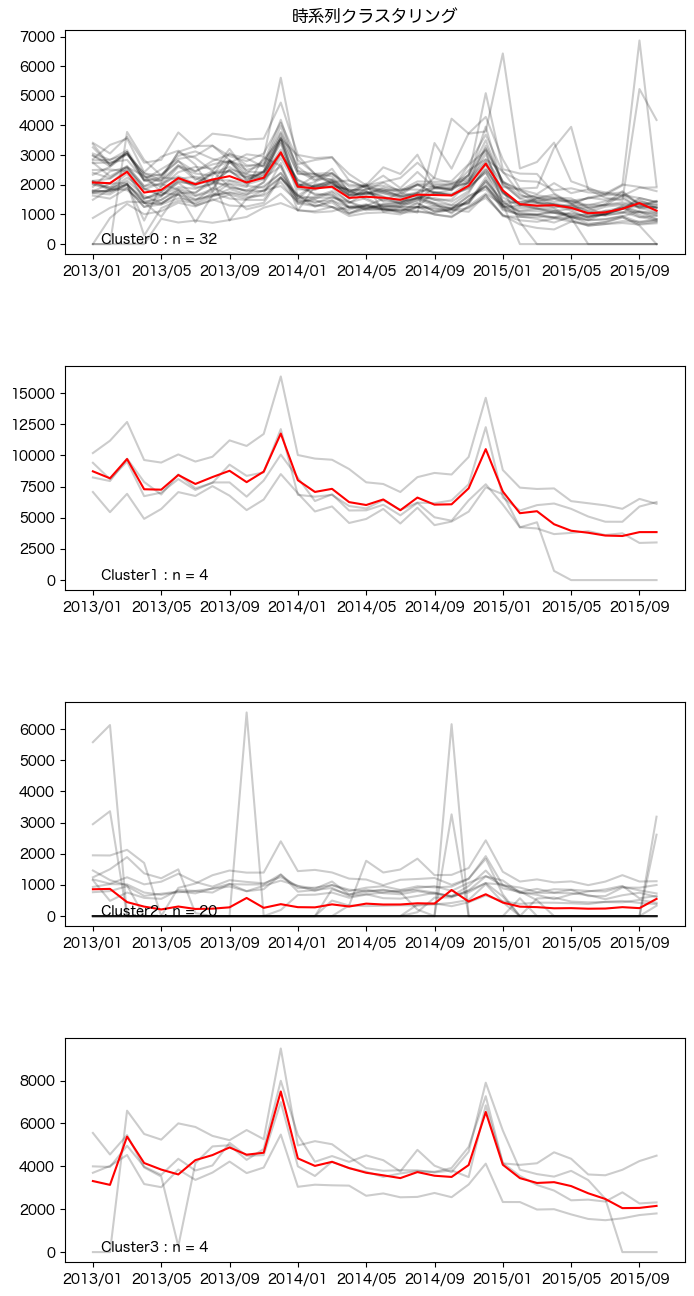

In [7]:
n = 4
km_euclidean = TimeSeriesKMeans(n_clusters=n, metric='euclidean', random_state=0)
labels_euclidean = km_euclidean.fit_predict(time_np)
print(labels_euclidean)

fig, axes = plt.subplots(n, figsize=(8,16))
plt.subplots_adjust(hspace=0.5)
for i in range(n):
    ax = axes[i]
    
    for x in time_np[labels_euclidean == i]:
        ax.plot(x.ravel(), 'k-', alpha=0.2)
    
    ax.plot(km_euclidean.cluster_centers_[i].ravel(), 'r-')
    
    datanum = np.count_nonzero(labels_euclidean == i)
    ax.text(0.5, (0.7+0.25), f'Cluster{(i)} : n = {datanum}')
    if i == 0:
        ax.set_title('時系列クラスタリング')
        
    ticks_space = 4
    ax.set_xticks(range(0, len(x_labels), ticks_space))
    ax.set_xticklabels([label for label in x_labels][::ticks_space])
    
plt.show()

[2 2 2 2 0 0 3 0 2 2 2 2 0 2 0 0 0 2 0 0 2 0 0 2 0 1 0 3 1 0 0 1 2 2 2 0 2
 0 0 2 2 0 3 0 0 0 0 0 2 2 0 0 0 0 1 0 0 3 0 0]


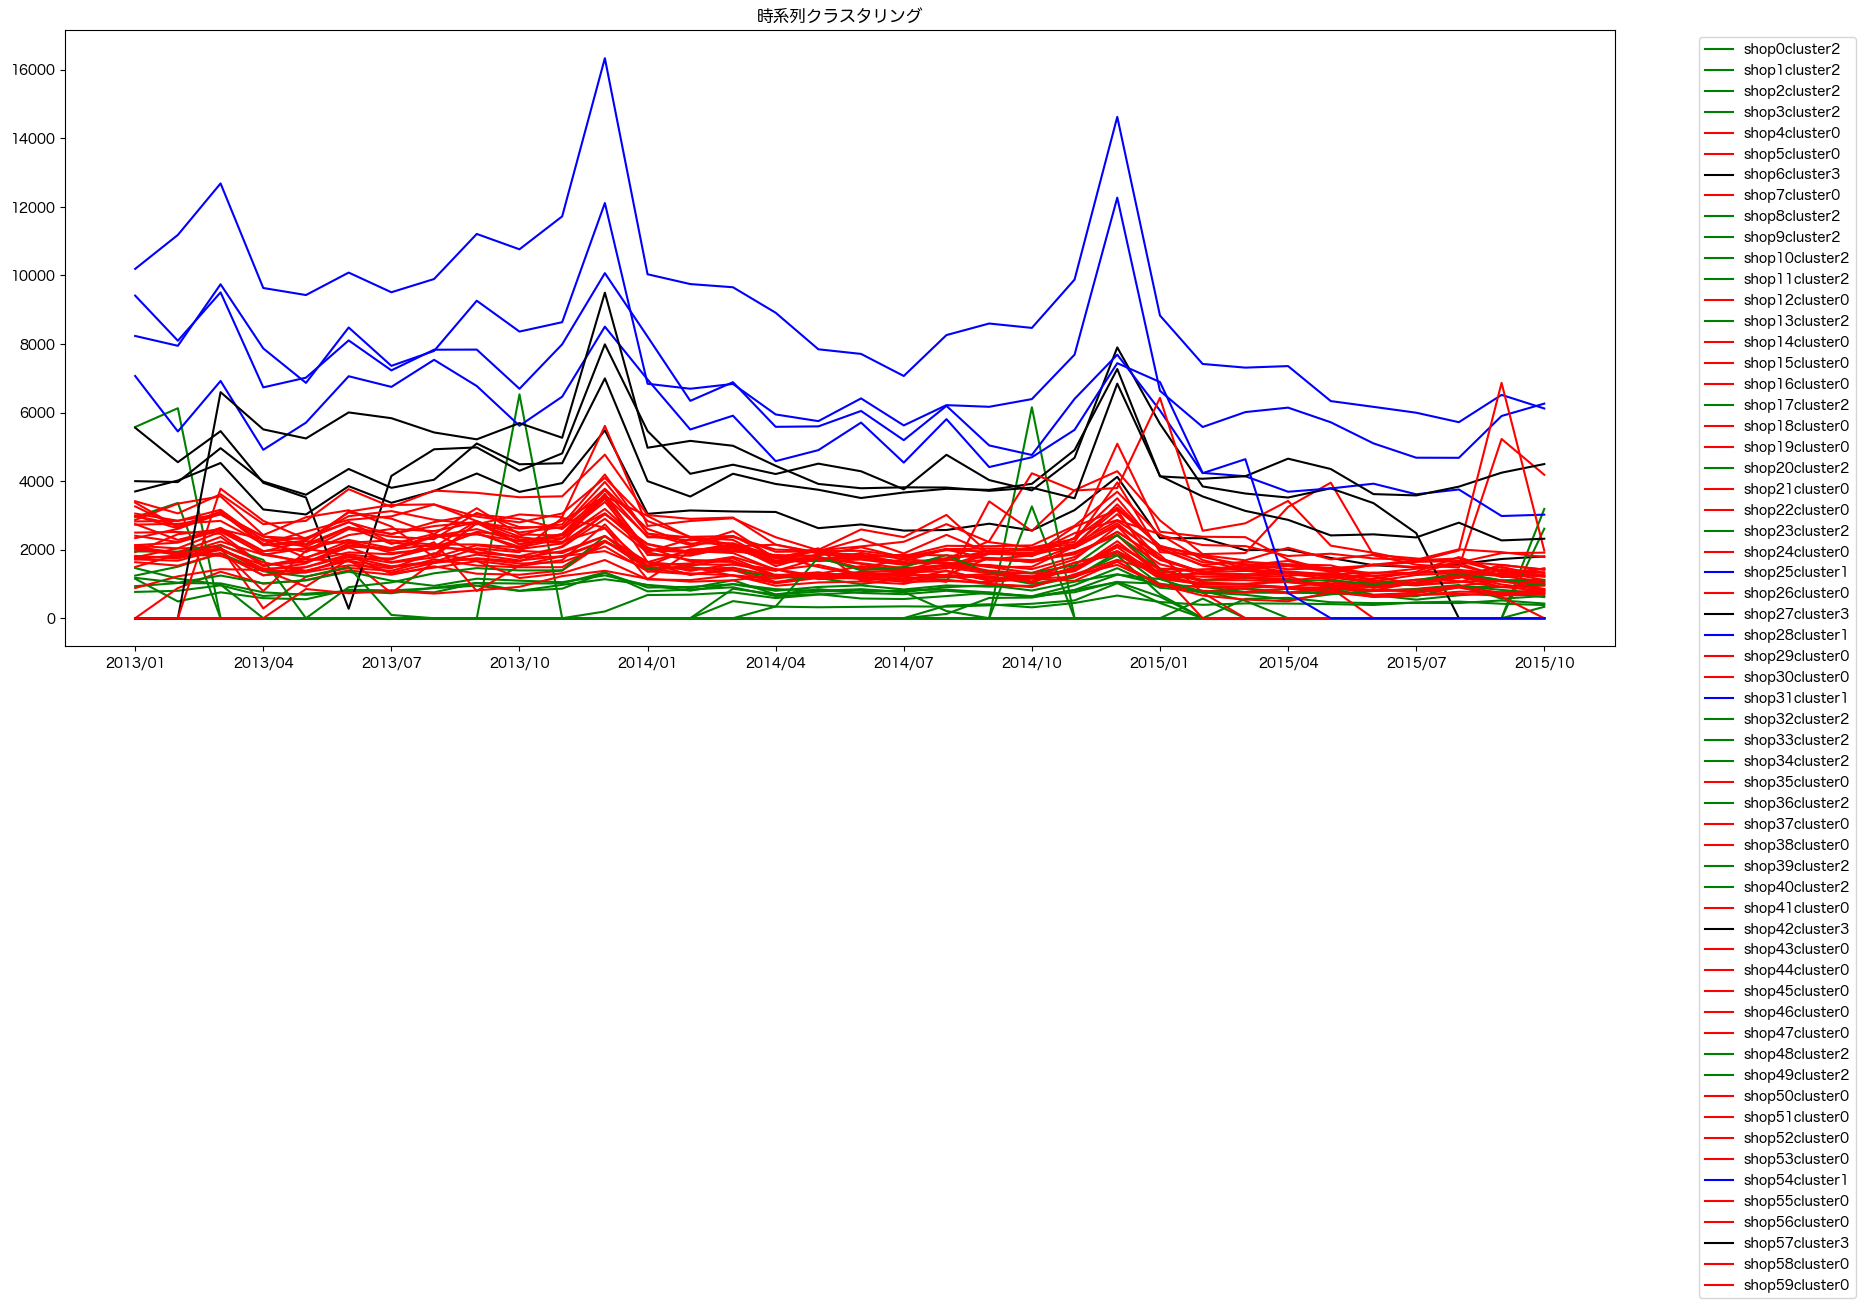

In [8]:
n = 4
km_euclidean = TimeSeriesKMeans(n_clusters=n, metric='euclidean', random_state=0)
labels_euclidean = km_euclidean.fit_predict(grouped)
print(labels_euclidean)

colors = pd.DataFrame(labels_euclidean).replace({0:'r', 1:'b', 2:'g', 3:'black'})

fig, ax = plt.subplots(figsize=(20, 8))
index = 0
for shop in grouped.T.columns:
    plt.plot(grouped.T.index, grouped.T[shop], label='shop'+str(shop)+'cluster'+str(labels_euclidean[index]), color=colors[0][index])
    index +=1
    
ticks_space = 3
ax.set_xticks(range(0, len(x_labels), ticks_space))
ax.set_xticklabels([label for label in x_labels][::ticks_space])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('時系列クラスタリング')
plt.show()

In [9]:
time_np = to_time_series_dataset(grouped)
scaler_np = TimeSeriesScalerMeanVariance().fit_transform(time_np)

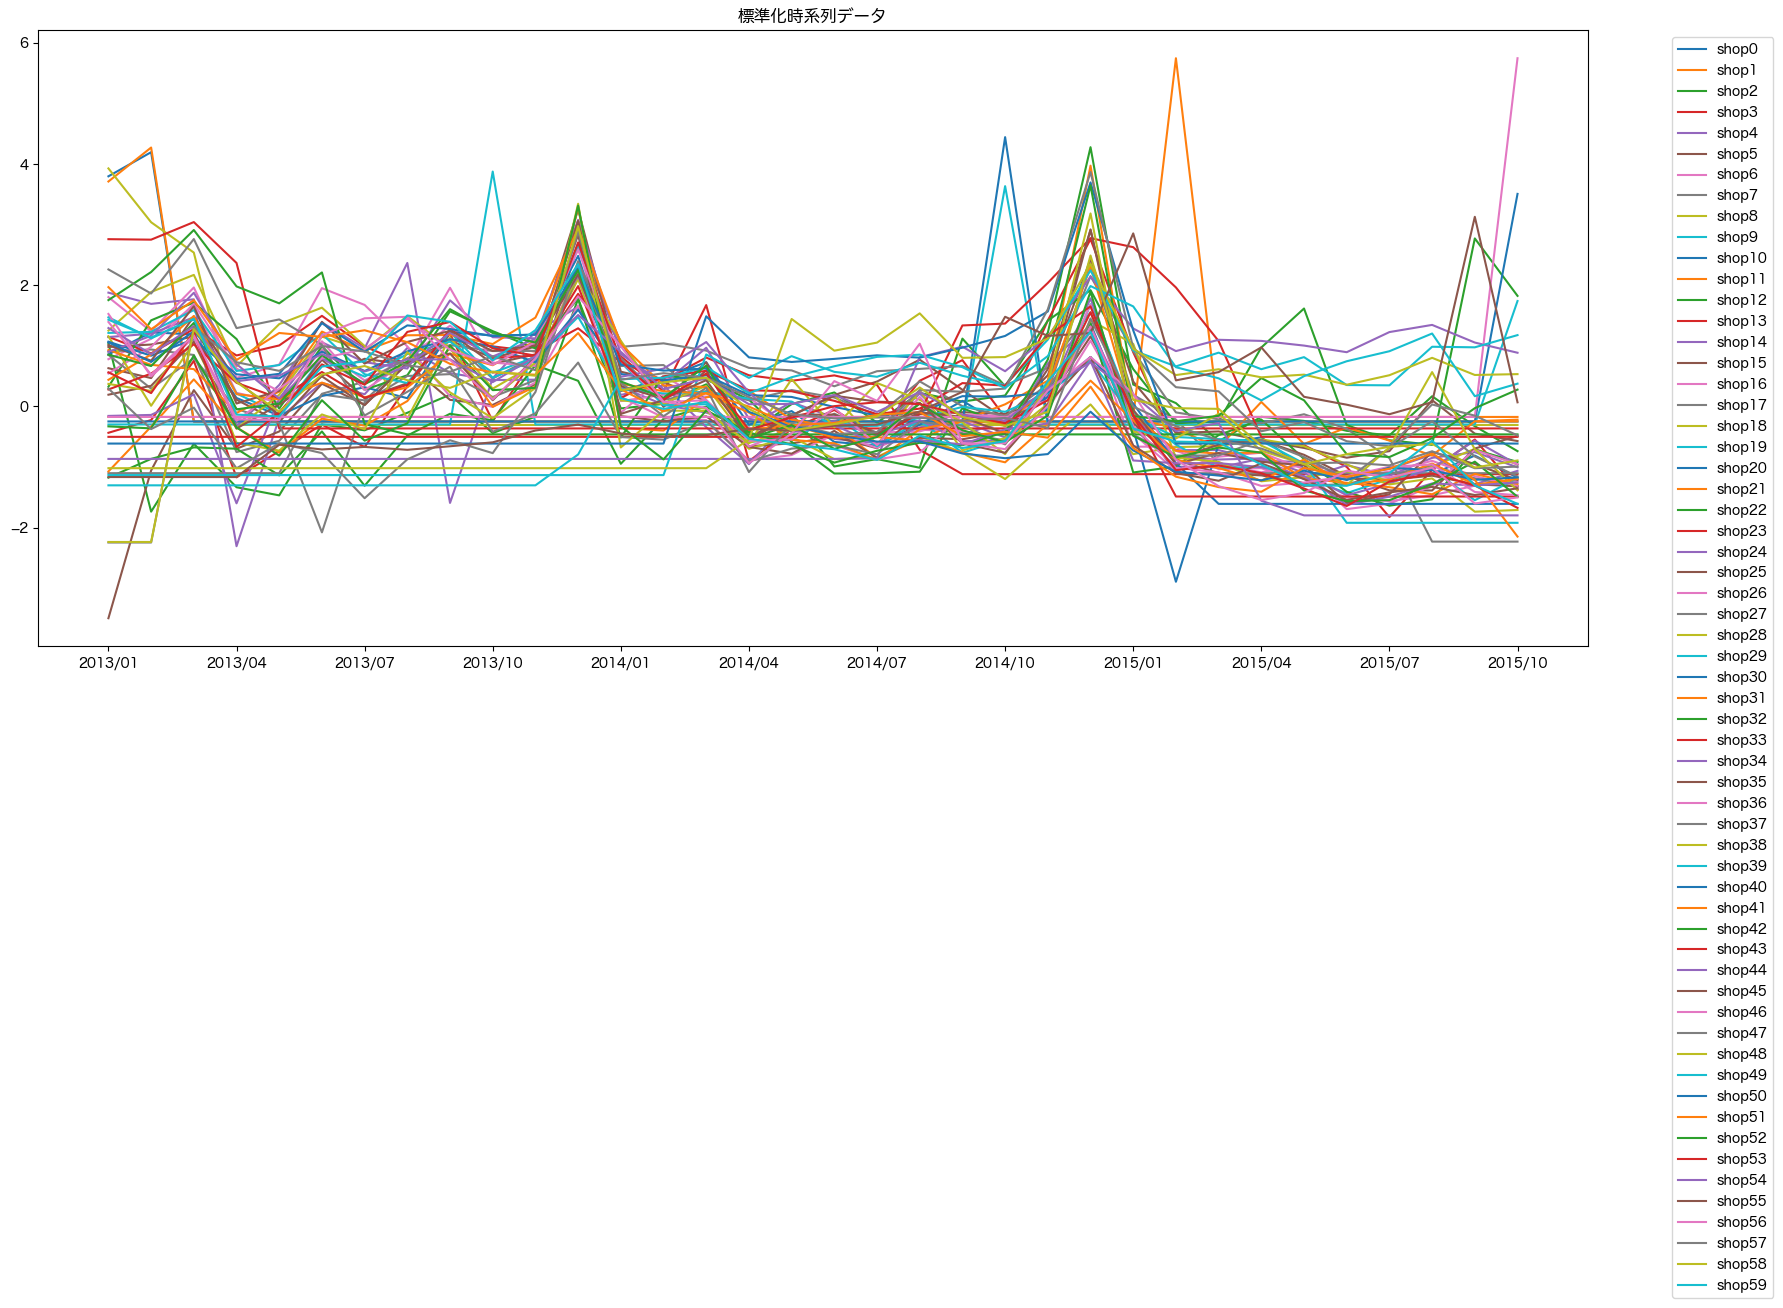

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))

for i, x in enumerate(scaler_np[:]):
    ax.plot(x, label='shop'+str(i))
    
ticks_space = 3
ax.set_xticks(range(0, len(x_labels), ticks_space))
ax.set_xticklabels([label for label in x_labels][::ticks_space])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('標準化時系列データ')
plt.show()

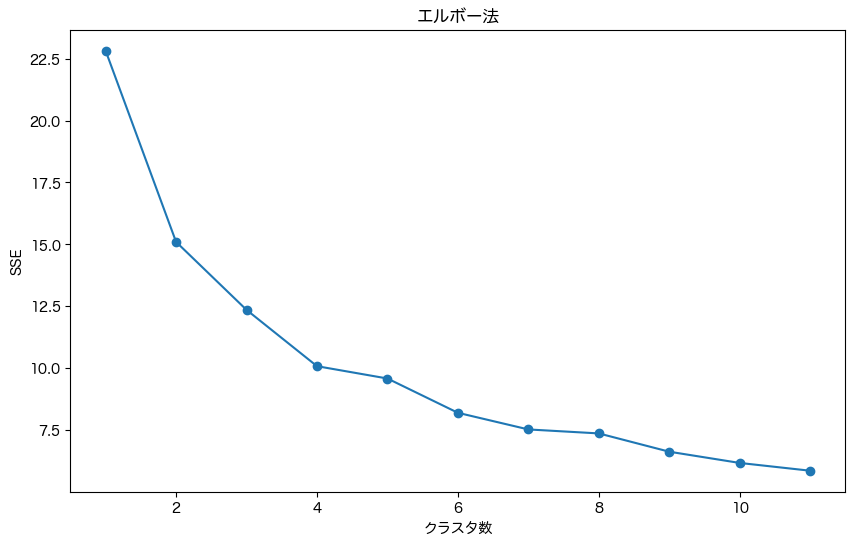

In [11]:
inertia = []
for n_cluster in range(1,12):
    km = TimeSeriesKMeans(n_clusters=n_cluster, metric='euclidean', random_state=0)
    km.fit(scaler_np)
    inertia.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(range(1,12), inertia, marker='o')
plt.xlabel('クラスタ数')
plt.ylabel('SSE')
plt.title('エルボー法')
plt.show()

[3 3 2 2 0 2 0 0 3 1 0 1 1 0 0 0 0 2 0 0 1 2 0 3 0 0 0 2 0 0 0 0 3 1 1 2 1
 3 2 1 1 0 2 0 0 0 0 2 1 1 0 0 0 0 0 1 0 2 2 0]


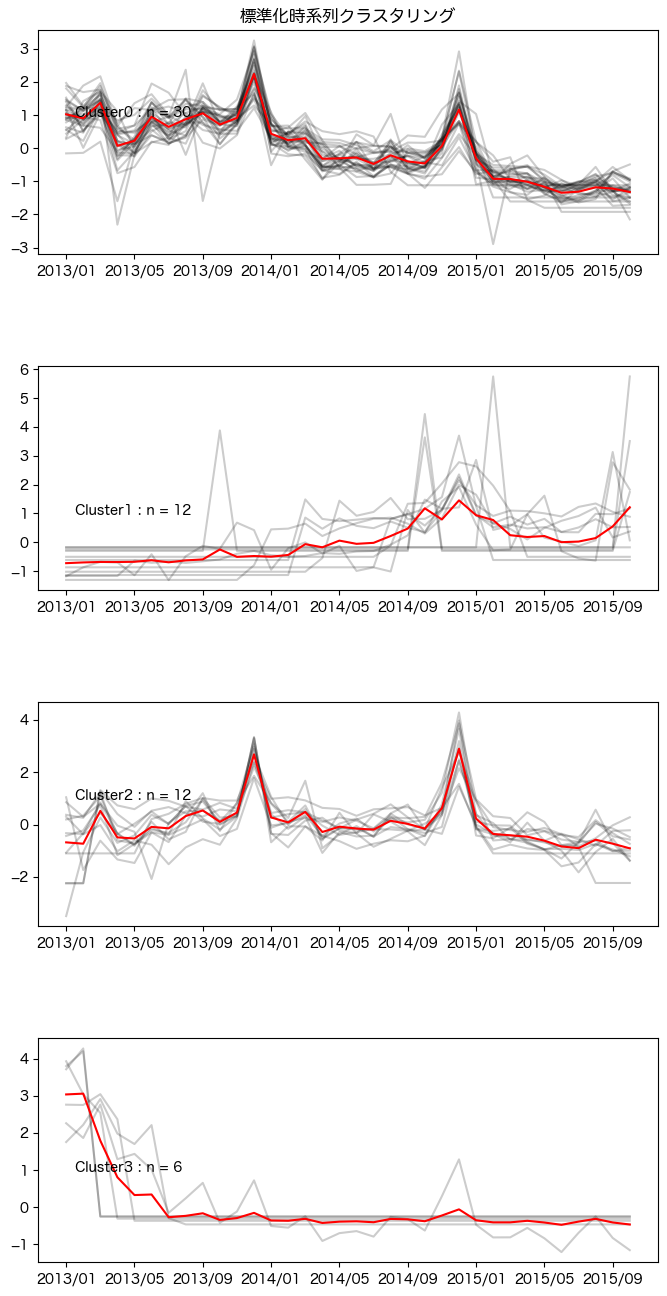

In [12]:
n = 4
km_euclidean = TimeSeriesKMeans(n_clusters=n, metric='euclidean', random_state=0)
labels_euclidean = km_euclidean.fit_predict(scaler_np)
print(labels_euclidean)

fig, axes = plt.subplots(n, figsize=(8,16))
plt.subplots_adjust(hspace=0.5)
for i in range(n):
    ax=axes[i]
    
    for x in scaler_np[labels_euclidean == i]:
        ax.plot(x.ravel(), 'k-', alpha=0.2)
        
    ax.plot(km_euclidean.cluster_centers_[i].ravel(), 'r-')
    
    datanum = np.count_nonzero(labels_euclidean == i)
    ax.text(0.5, (0.7+0.25), f'Cluster{i} : n = {datanum}')
    if i == 0:
        ax.set_title('標準化時系列クラスタリング')
    
    ticks_space = 4
    ax.set_xticks(range(0, len(x_labels), ticks_space))
    ax.set_xticklabels([label for label in x_labels][::ticks_space])
    
plt.show()

In [13]:
scaler_np = scaler_np.reshape((scaler_np.shape[0], -1))

shops = []
for i in range(60):
    shops.append('shop'+str(i))
    
scaler_df = pd.DataFrame(scaler_np, index=shops, columns=x_labels)
scaler_df.head()

,2013/01,2013/02,2013/03,2013/04,2013/05,2013/06,2013/07,2013/08,2013/09,2013/10,...,2015/01,2015/02,2015/03,2015/04,2015/05,2015/06,2015/07,2015/08,2015/09,2015/10
shop0,3.796228,4.194439,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,...,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708,-0.249708
shop1,3.710584,4.270925,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,...,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422,-0.249422
shop2,1.039471,-1.736564,-0.616924,-1.333997,-1.468186,-0.298225,-0.394674,-0.105329,0.192403,-0.440801,...,0.360140,0.054021,-0.574990,-0.172423,-0.239518,-0.403060,-0.478542,0.167243,-0.327579,-0.738533
shop3,-0.435641,-0.225545,0.750786,-1.170979,-0.738427,-0.299697,-0.670455,0.330593,1.195696,-0.244083,...,0.892910,-0.608662,-0.559227,-0.596303,-0.639559,-0.997958,-1.825986,-1.047393,-0.546869,-1.368717
shop4,1.876696,1.691508,1.766955,-2.307188,-0.192383,0.386044,0.200856,0.964472,0.548370,0.434056,...,-0.238109,-0.720513,-0.720513,-0.901129,-0.914847,-1.141188,-1.033733,-0.795960,-1.285223,-1.063454


[3 3 2 2 0 2 0 0 3 1 0 1 1 0 0 0 0 2 0 0 1 2 0 3 0 0 0 2 0 0 0 0 3 1 1 2 1
 3 2 1 1 0 2 0 0 0 0 2 1 1 0 0 0 0 0 1 0 2 2 0]


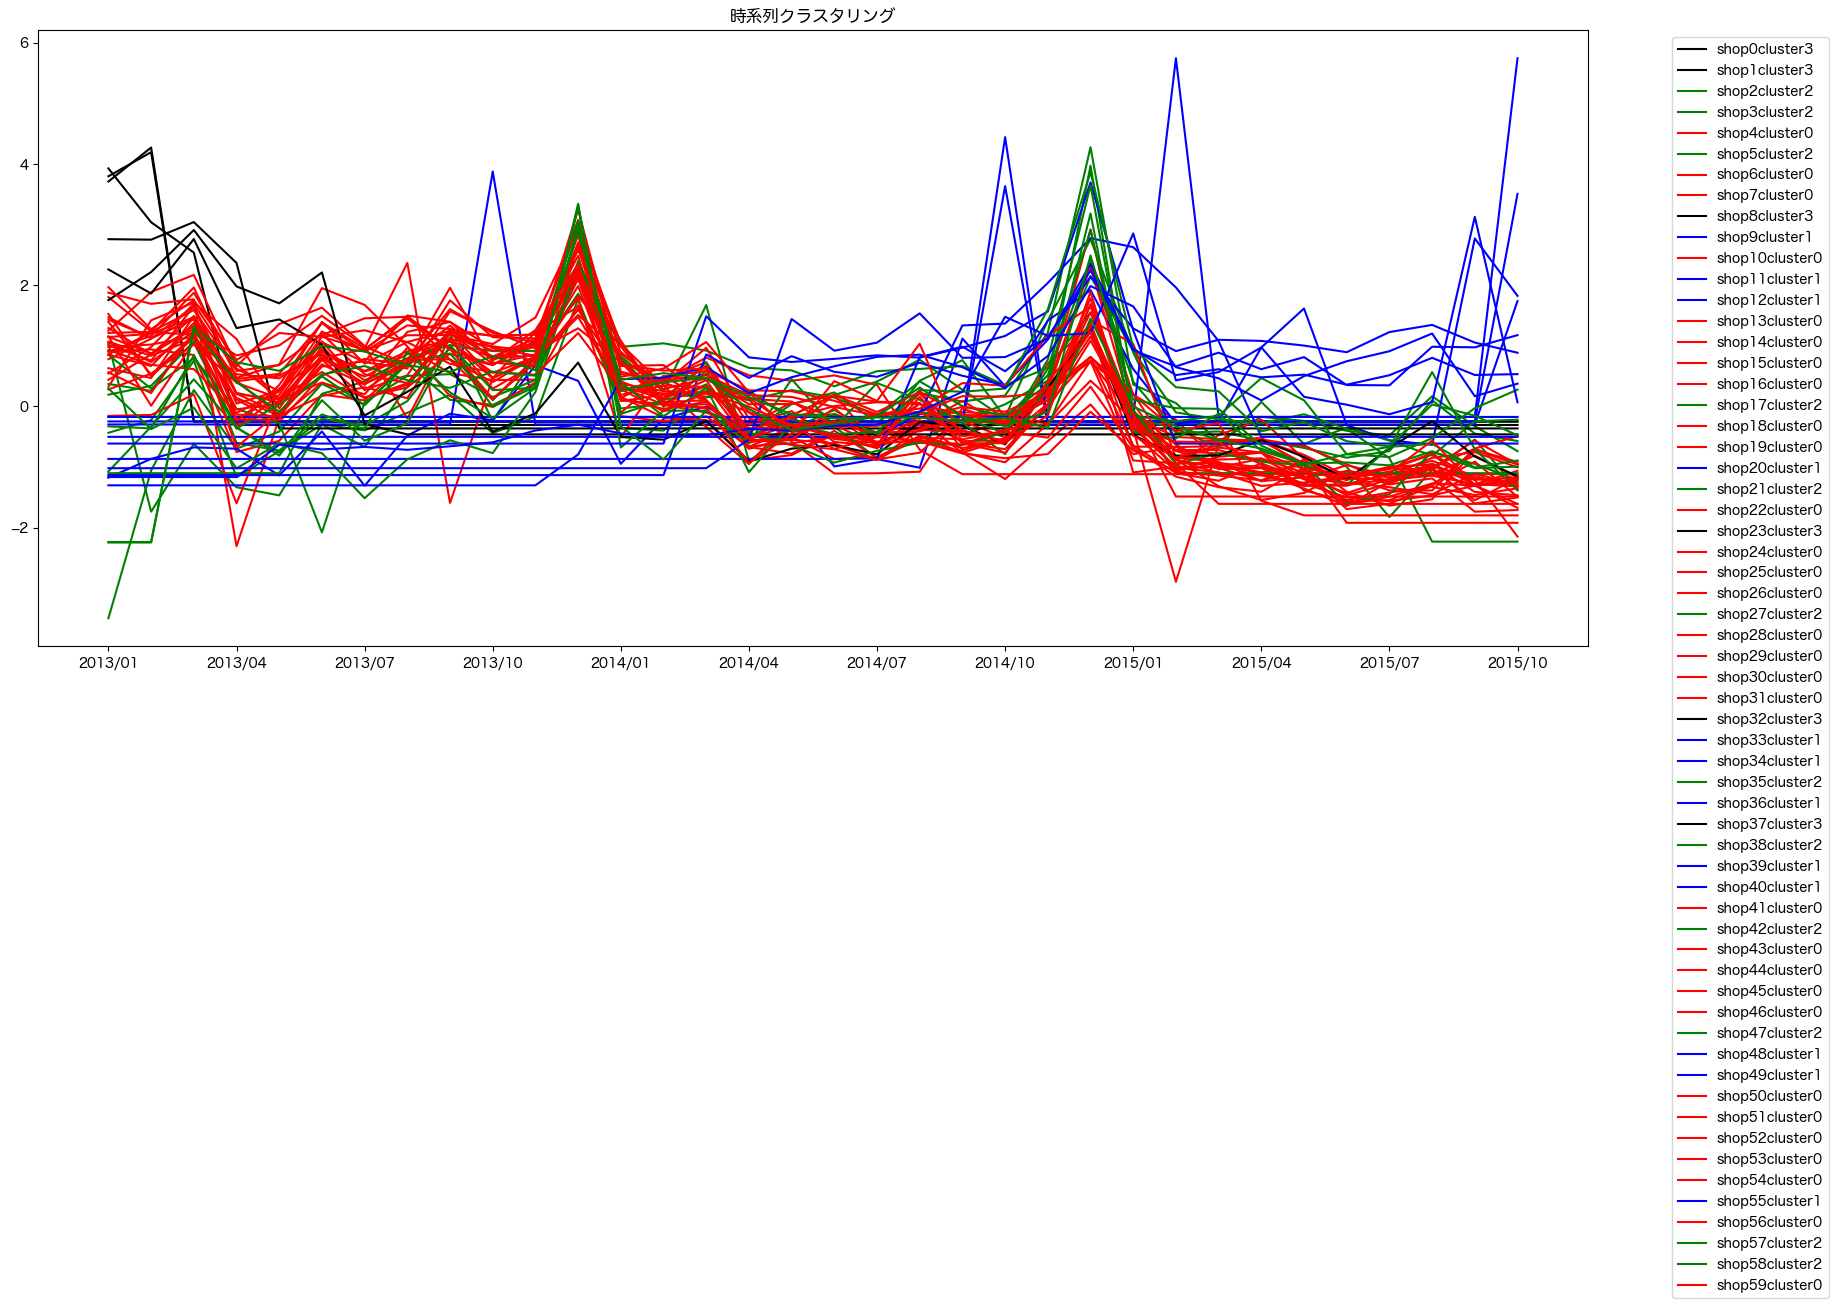

In [14]:
n = 4
km_euclidean = TimeSeriesKMeans(n_clusters=n, metric='euclidean', random_state=0)
labels_euclidean = km_euclidean.fit_predict(scaler_df)
print(labels_euclidean)

colors = pd.DataFrame(labels_euclidean).replace({0:'r', 1:'b', 2:'g', 3:'black'})

fig = plt.figure(figsize=(20, 8))
index = 0
for shop in scaler_df.T.columns:
    plt.plot(scaler_df.T.index, scaler_df.T[shop], label=str(shop)+'cluster'+str(labels_euclidean[index]), color=colors[0][index])
    index += 1
    
ticks_space = 3
plt.xticks(range(0, len(x_labels), ticks_space), [label for label in x_labels][::ticks_space])

plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.title('時系列クラスタリング')
plt.show()